In [2]:
from sklearn.datasets import make_blobs
import numpy as np
X, y = make_blobs(n_samples=100, centers=2, n_features=2,
                  random_state=42, cluster_std=6)

In [25]:
def log_posterior(X, y, w, reg=1.0):
    n_prior = -0.5 * reg * w.dot(w)
    # logit
    z = X.dot(w)
    n_log_likelihood = -np.sum(np.log(1+np.exp(-z)) + (1-y)*z)
    return n_prior + n_log_likelihood

def negative_log_posterior(w, X, y, reg=1.0):
    return -log_posterior(X, y, w, reg)


In [26]:
def bayesian_logistic(X, y, reg=1.0):
    w = np.zeros(X.shape[1])
    solution = scipy.optimize.minimize(negative_log_posterior, w, 
                                       args=(X, y), method='BFGS')
    w_map = solution.x
    neg_log_map = solution.fun
    
    m = w_map
    p = 1/(1+np.exp(-X.dot(w_map)))
    # sigmoid hession
    hessian = p * (1-p) 
    precision = X.T@(X*hessian.reshape(X.shape[0], -1)) + reg
    return m, precision, neg_log_map
    

In [43]:
def bayesian_negative_log(w, w_map, H, neg_log_map):
    diff = (w-w_map)
    return neg_log_map + 0.5 * diff.T @ H @ diff

In [28]:
import scipy.optimize
w_0 = np.zeros(X.shape[1]) # initial guess
solution = scipy.optimize.minimize(negative_log_posterior, w_0, args=(X, y), method='BFGS')
w_map = solution.x
hessian = np.linalg.inv(solution.hess_inv)

In [30]:
solution, hessian

(      fun: 41.323422531234314
  hess_inv: array([[ 0.00422423, -0.00049535],
        [-0.00049535,  0.00120478]])
       jac: array([1.90734863e-06, 2.86102295e-06])
   message: 'Optimization terminated successfully.'
      nfev: 33
       nit: 8
      njev: 11
    status: 0
   success: True
         x: array([ 0.32083871, -0.08857936]),
 array([[248.7212755 , 102.26209404],
        [102.26209404, 872.07471102]]))

In [38]:
w_map, hessian, neg_log_map = bayesian_logistic(X, y)
w_map, hessian, neg_log_map

(array([ 0.32083871, -0.08857936]),
 array([[253.96683038, 120.37065478],
        [120.37065478, 928.19825532]]),
 41.323422531234314)

In [44]:
w_0 = np.zeros(X.shape[1])
bayesian_negative_log(w_0, w_map, hessian, neg_log_map)

54.61534123523802

In [62]:
import matplotlib.pyplot as plt

# Let's evalaute the posterior over a grid 
rranges = (slice(-4, 4, 0.1), slice(-4, 4, 0.1))
grid_sol = scipy.optimize.brute(negative_log_posterior, rranges, args=(X, y),
                                full_output=True)
# pull out components
best_w = grid_sol[0]
w_i0, w_i1, n_log_posteriors = grid_sol[2][0], grid_sol[2][1],  grid_sol[3]

In [63]:
# we'll do the same for the laplace approximation
laplace_surface = scipy.optimize.brute(bayesian_negative_log, rranges, 
                                       args=(w_map, hessian, neg_log_map),
                                       full_output=True)
neg_log_laplace = laplace_surface[3]

In [68]:
n_log_posteriors, neg_log_laplace

(array([[1912.05232082, 1899.36199252, 1887.11564237, ..., 3082.24878941,
         3124.28218874, 3166.63235302],
        [1877.22765423, 1863.99401745, 1851.31090112, ..., 3043.818013  ,
         3086.13955884, 3128.73389453],
        [1843.05923435, 1829.19529442, 1815.9579284 , ..., 3005.66972295,
         3048.24320929, 3091.05365577],
        ...,
        [ 571.07667256,  553.43999518,  536.00307556, ..., 1211.58140845,
         1250.39864345, 1289.84972954],
        [ 567.74043628,  550.29587611,  533.06150976, ..., 1206.30652794,
         1244.55831926, 1283.37176542],
        [ 564.61100591,  547.36320291,  530.34494736, ..., 1201.49432951,
         1239.29838003, 1277.55757649]]),
 array([[11546.74808273, 11136.32147405, 10735.17684792, ...,
          7102.98016492,  7407.26621283,  7720.8342433 ],
        [11391.20091924, 10981.97801711, 10582.03709753, ...,
          7040.11840562,  7345.60816008,  7660.3798971 ],
        [11238.19342407, 10830.17422848, 10431.43701545, ...,

<IPython.core.display.Javascript object>


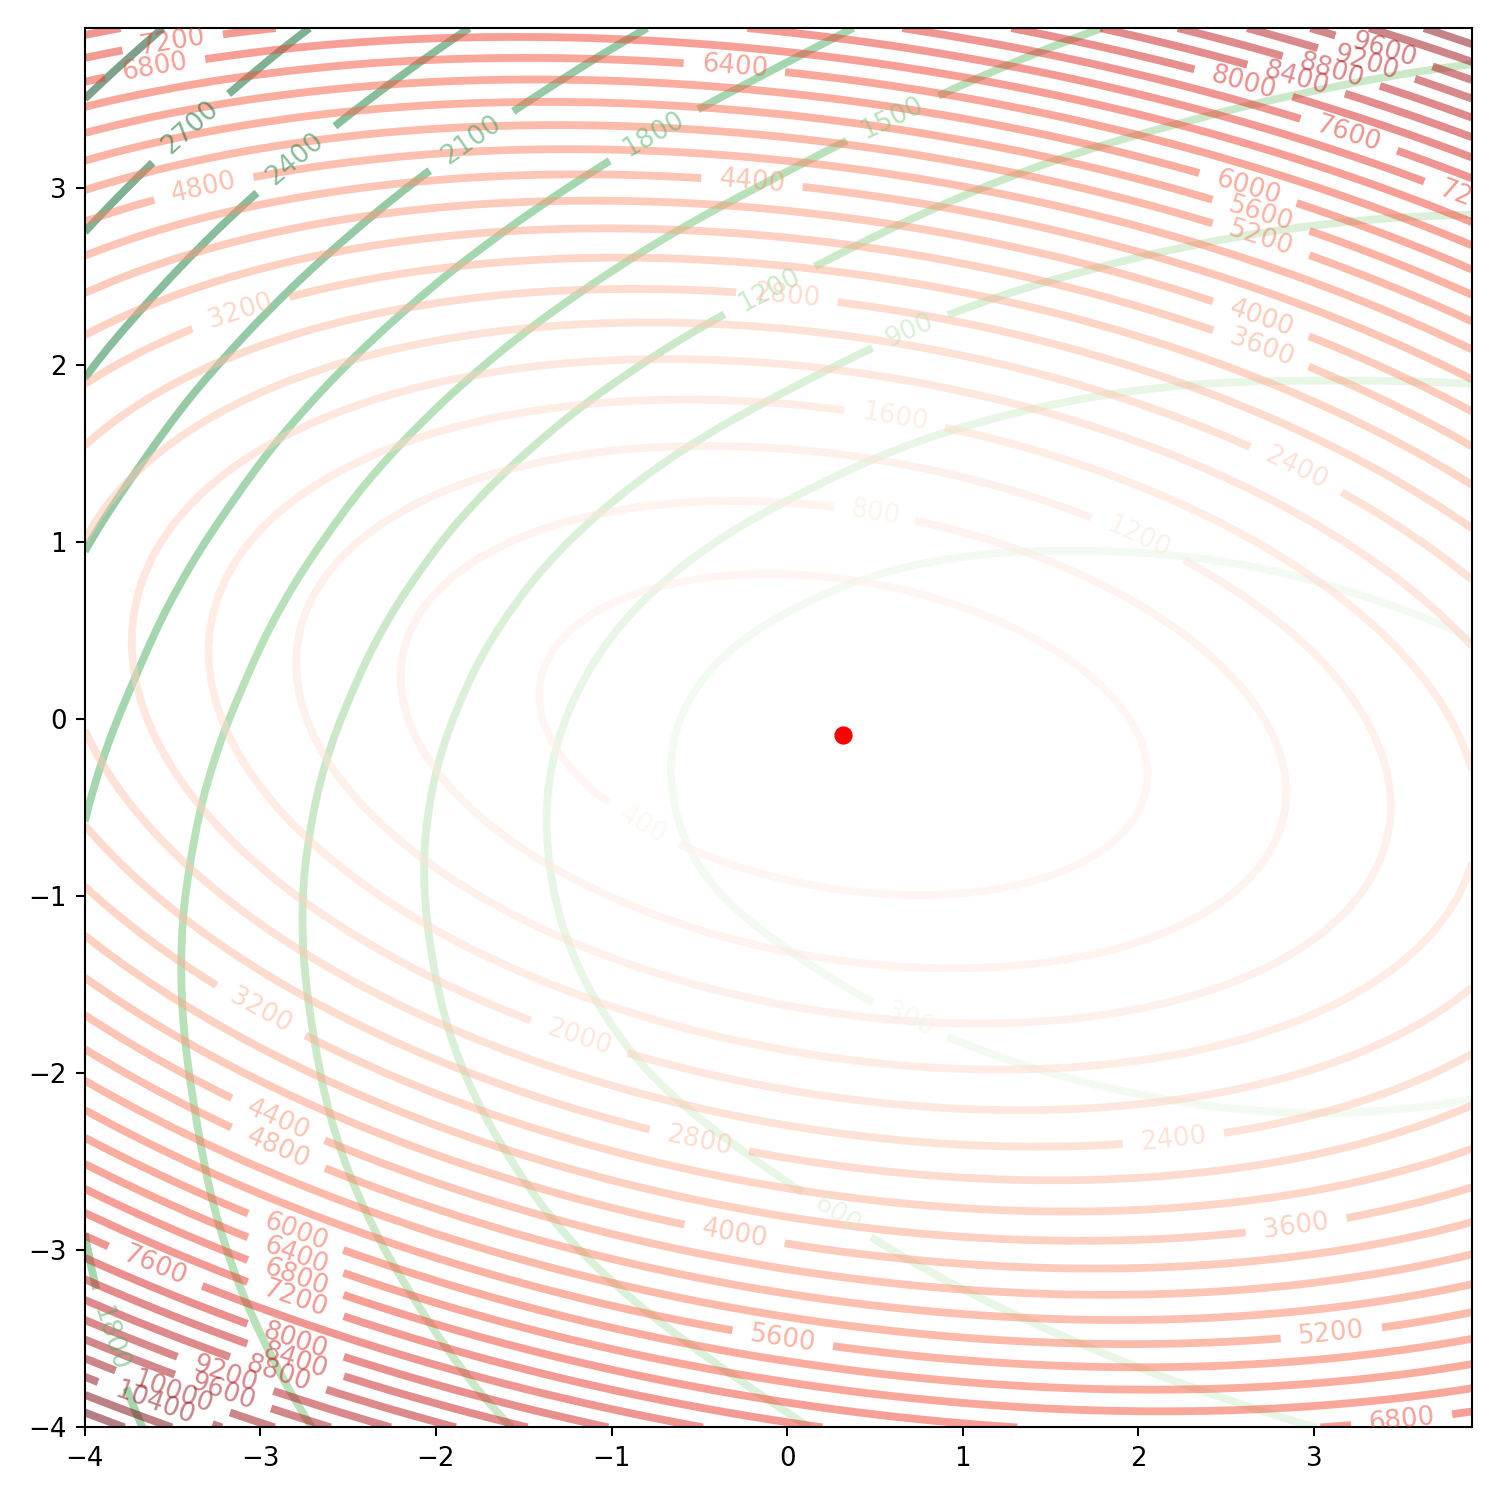

In [66]:
# plot surface of the model
fig = plt.figure(figsize=(8,8))
ax = plt.subplot(111)

CS = ax.contour(w_i0, w_i1, n_log_posteriors, alpha=.5, cmap='Greens',linewidths=3, levels=10, extend='max')
plt.clabel(CS, inline=1, fontsize=10)
ax.plot(best_w[0], best_w[1], 'ro')

CS = ax.contour(w_i0, w_i1, neg_log_laplace, alpha=.5, cmap='Reds',linewidths=3, levels=30, extend='max')
plt.clabel(CS, inline=1, fontsize=10)

plt.tight_layout()

As we can the contours lapalace approximation is not exactly match neg log probability